Microbiome analysis

In [1]:
from preprocessing import readcounts_processing_pipeline, pheno_processing_pipeline
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os 
import numpy as np
from skbio.diversity import beta_diversity, alpha_diversity
load_dotenv()
root = os.environ.get("root_folder")

In [2]:
from preprocessing import load_data
pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(root)
 

In [4]:
df =  readcounts_df_train
# Remove columns with unique values:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1) 
        
df = pheno_df_train.join(df)

In [5]:
X = df.loc[:, readcounts_df_train.columns]
X_binary = X.copy()
X_binary = X_binary !=0
X_binary = X_binary.to_numpy()
X_binary.shape

 
y = df.Event

# Alpha diversity

First, we’ll compute observed OTUs, an alpha diversity metric, for each sample using the alpha_diversity driver function:

In [3]:
from skbio.diversity import alpha_diversity
pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(root)

X_train= readcounts_df_train.to_numpy()
X_test= readcounts_df_test.to_numpy()
ids_train = readcounts_df_train.index
ids_test = readcounts_df_test.index
adiv_train= alpha_diversity('observed_otus', X_train, ids_train).to_numpy().reshape(-1,1)
adiv_test= alpha_diversity('observed_otus', X_test, ids_test).to_numpy().reshape(-1,1)
 

Check if alpha diversity is related to HF risk

In [49]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

y_train = pheno_df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
y_test =  pheno_df_test.loc[:,['Event', 'Event_time']].to_records(index=False)

model.fit(adiv_train, y_train) 
 
from model_evaluation import evaluate_model
evaluate_model(model, adiv_train, adiv_test, y_train, y_test)

,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.512318,0.482817,0.018361,9.52e-01
test,0.475298,0.532707,0.018153,7.27e-02


Next we’ll compute Faith’s PD on the same samples. Since this is a phylogenetic diversity metric, we’ll first create a tree and an ordered list of OTU identifiers.

In [22]:
from taxonomy import newickify_taxonomy

txy = newickify_taxonomy()

In [23]:
from skbio import TreeNode
from io import StringIO
tree = TreeNode.read(StringIO(
                     txy))
 
print(tree.ascii_art())

                                                                      /-s  
                    /p  ----- /c  ----- /o  ----- /f  ----- /g  -----|
                   |                                                  \-nan
                   |
                   |                                                  /-s  
                   |-p  Candidatus Korarchaeota-- /f  ----- /g  -----|
                   |                                                  \-nan
                   |
                   |                                                  /-s  
                   |                    /o  ----- /f  ----- /g  -----|
                   |                   |                              \-nan
                   |                   |
                   |                   |          /f  Acidilobaceaedilobus Acidilobus saccharovorans
                   |                   |-o  Acidilobales
                   |                   |          \f  Caldisphaeraceaephaeraaldisphaera la

In [26]:
tree.root()

<TreeNode, name: root, internal node count: 5050, tips count: 11014>

In [29]:
tree.is_root()

True

In [24]:
otu_ids = readcounts_df_train.columns
adiv_faith_pd = alpha_diversity('faith_pd', data, ids=ids,
                                otu_ids=otu_ids, tree=tree)
adiv_faith_pd

ValueError: ``tree`` must be rooted.

# Beta diversity

Now we’ll compute Bray-Curtis distances, a beta diversity metric, between all pairs of samples. Notice that the data and ids parameters provided to beta_diversity are the same as those provided to alpha_diversity.

In [4]:
from skbio.diversity import beta_diversity


X_train= readcounts_df_train.to_numpy()
X_test= readcounts_df_test.to_numpy()
ids_train = readcounts_df_train.index
ids_test = readcounts_df_test.index
bdiv_train= beta_diversity("braycurtis", X_train, ids_train)
bdiv_test= beta_diversity("braycurtis", X_test, ids_test)

 

In [21]:
from skbio.stats.ordination import pcoa

In [23]:
from skbio.stats.ordination import pcoa
 

pcoa = pcoa(bdiv_train, number_of_dimensions=3) 

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.2441535676264 and the largest is 139.77294683812394.
  RuntimeWarning


/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/skbio/stats/ordination/_ordination_results.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


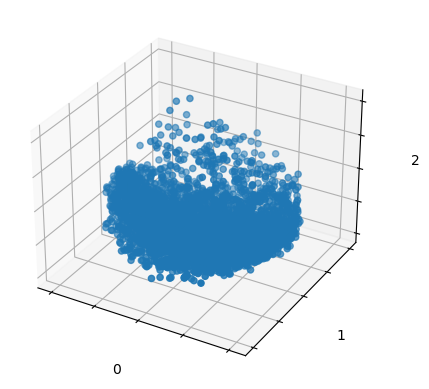

In [26]:
pcoa

In [ ]:
X_test_pca = pcoa(bdiv_test, number_of_dimensions=3)

In [52]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

model.fit(X_train_pca, y_train) 
 
from model_evaluation import evaluate_model
evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)

ValueError: setting an array element with a sequence.

Next, we’ll compute weighted UniFrac distances between all pairs of samples. Because weighted UniFrac is a phylogenetic beta diversity metric, we’ll need to pass the skbio.TreeNode and list of OTU ids that we created above. Again, these are the same values that were provided to alpha_diversity.

In [69]:
wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree,
                       otu_ids=otu_ids)
print(wu_dm)

ValueError: ``tree`` must be rooted.

Next we’ll do some work with these beta diversity distance matrices. First, we’ll determine if the UniFrac and Bray-Curtis distance matrices are significantly correlated by computing the Mantel correlation between them. Then we’ll determine if the p-value is significant based on an alpha of 0.05.

In [ ]:
from skbio.stats.distance import mantel
r, p_value, n = mantel(wu_dm, bc_dm)
print(r)

alpha = 0.05
print(p_value < alpha)


Next, we’ll perform principal coordinates analysis (PCoA) on our weighted UniFrac distance matrix.

In [70]:
from skbio.stats.ordination import pcoa
wu_pc = pcoa(wu_dm)

NameError: name 'wu_dm' is not defined

However, wedetected a robust and significant signal between beta diversity, or the overall community variation and elevated mortality risk. We used the standard centred log-ratio (CLR) transformation to reduce compositionality bias in taxonomic abundance data and observed that the third principal component of the CLR-transformed  species  abundance  matrix  (PC3)  was  strongly linked to all-cause mortality risk (hazard ratio (HR), 1.14; 95%confidence interval (CI), 1.07–1.23; FDR-correctedP=0.001,two-tailed Wald test for Cox regression coefficient, Fig.2andSupplementary Table 1). Salosensaari 2021

## Genus-level analysis

"In addition to analysing the overall
species diversity, we have focused on the 91 genus-level taxo-
nomic groups that were detected in >1% of the study participants
at a within-sample relative abundance of >0.1%"

In [16]:
from preprocessing import taxa_filtering, centered_log_transform, load_data, taxa_aggregation

pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(root)
y_train = pheno_df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
y_test = pheno_df_test.loc[:,['Event', 'Event_time']].to_records(index=False)

readcounts_df_train = taxa_aggregation(readcounts_df_train)
selection = taxa_filtering(readcounts_df_train)
readcounts_df_train = readcounts_df_train.loc[:,selection]
X_clr_train = centered_log_transform(readcounts_df_train) 

readcounts_df_test = taxa_aggregation(readcounts_df_test)
readcounts_df_test = readcounts_df_test.loc[:,selection]
X_clr_test = centered_log_transform(readcounts_df_test) 

In [17]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

model.fit(X_clr_train, y_train) 
 
from model_evaluation import evaluate_model
evaluate_model(model, X_clr_train, X_clr_test, y_train, y_test)

,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.655097,0.658996,0.018126,2.08e-02
test,0.476957,0.518062,0.018487,5.84e-02


## PCA

[0.11636451 0.06470683 0.05318672 0.04684956 0.0317707  0.02641483
 0.0230089  0.01866936 0.017017   0.01543448 0.01419638 0.01417819
 0.01379805 0.01343768 0.01234905 0.01190668 0.01158564 0.01127925
 0.01086131 0.01055686 0.01036856 0.01026029 0.01002442 0.00993695
 0.00976999 0.00950795 0.00941742 0.00921242 0.00902195 0.00871284]
[199.33695611 148.64578747 134.7656285  126.4824642  104.15760051
  94.9732881   88.63912691  79.84399395  76.22880115  72.59782264
  69.62519608  69.58056399  68.64145523  67.73913477  64.93730714
  63.76359673  62.89809371  62.06082842  60.90020462  60.04059276
  59.50272302  59.19121772  58.50692392  58.2510881   57.75966917
  56.97979524  56.70787994  56.08729916  55.50444271  54.54530926]


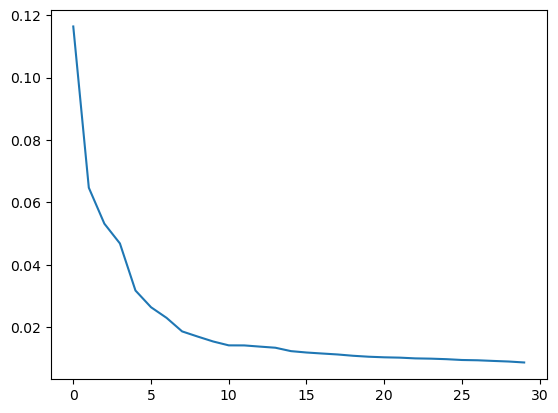

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=30)
scaler = StandardScaler()

scaler = scaler.fit(X_clr_train)
pca = pca.fit(scaler.transform(X_clr_train))

X_train_pca = pca.transform(scaler.transform(X_clr_train))
X_test_pca = pca.transform(scaler.transform(X_clr_test))

plt.plot(pca.explained_variance_ratio_)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

model.fit(X_train_pca, y_train) 
 
from model_evaluation import evaluate_model
evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)

,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.577801,0.606918,0.018292,5.40e-01
test,0.494436,0.527096,0.018196,1.86e-01


Hazard ratios

In [33]:
np.exp(model.coef_)

array([0.99908511, 0.98533287, 0.99848844, 1.00904086, 0.98403778,
       1.00857752, 0.96239019, 0.99612812, 0.98589964, 1.01300255,
       1.03599681, 0.96468401, 1.02226237, 0.98344602, 1.01882444,
       1.01018239, 1.01430907, 0.98673985, 1.07210617, 0.98750618,
       0.9521639 , 0.95979493, 0.92094223, 0.99809487, 0.992267  ,
       1.01539916, 1.00675658, 1.08191529, 1.08697162, 1.00404907])

## Focus on Enterobacteriaceae

In [3]:
cols = ['Enterobacteriaceae' in el for el in readcounts_df_train.columns]
df_entbact_train = readcounts_df_train.loc[:, cols]
df_entbact_test = readcounts_df_test.loc[:, cols]
df_train = pheno_df_train.join(df_entbact_train)
df_test  = pheno_df_test.join(df_entbact_test)

In [23]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = df_entbact_train.columns
X_train = df_train.loc[:,covariates]
y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
model.fit(X_train, y_train) 
 
X_test = df_test.loc[:,covariates]
y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
from model_evaluation import evaluate_model
evaluate_model(model, X_train, X_test, y_train, y_test)


,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.622027,0.617229,0.017968,4.96e-01
test,0.488511,0.468272,0.019106,2.32e-01


Note that Salosensaari et al (2021) found the same C-index using random forests (0.62 for deaths due to cardiovascular events).

In [24]:
H_coeff = np.exp(model.coef_)
plt.hist(H_coeff)

[0.9990132  1.00617462 0.65264753 0.96398418 1.23494556 1.04882661
 0.95705409 0.94778714 0.92356221 0.92450091 1.00836053 1.00783052
 0.63968115 0.75725072 1.03271646 1.02479965 0.99945651 0.63417363
 1.00070157 0.99999653 0.99959044 0.2021853  0.99709186 0.99874647
 0.98464678 1.00000116 1.00191859 1.00193194 0.19119412 1.00017244
 0.99867917 1.00001429 0.99853618 0.35387571 1.00047158 1.00168371
 1.00101998 0.99339116 1.00024059 1.00263441 1.00130963 0.99942358
 1.01324327 0.99990537 1.00003078 1.00125805 0.99696953 1.00048485
 1.00160319 1.04322358 1.01588877 0.9950989  1.00022863 0.99239265
 1.00070476 0.88738299 1.00006844 0.69917639 0.99904676 1.00041133
 1.00050942 0.99923575 1.07673411 0.99794042 0.99995386]


Select the bacteria with hazard coefficients p% larger or smaller than standard deviation

In [50]:
p = 10
selection = abs(H_coeff-1) > p/100*np.std(H_coeff)
print(np.mean(selection))

0.3076923076923077


In [51]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = df_entbact_train.columns[selection]
X_train = df_train.loc[:,covariates]
y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
model.fit(X_train, y_train) 
 
X_test = df_test.loc[:,covariates]
y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
from model_evaluation import evaluate_model
evaluate_model(model, X_train, X_test, y_train, y_test)


,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.557111,0.531110,0.018341,8.69e-01
test,0.525019,0.477171,0.018184,5.47e-01


Note that selecting only these bacteriathis improves performance on test set

## +   Lactobacillaceae + Clostridiaceae
## + Collinsella, Blautia, Salmonella, Campylobacter, Shigella, Yersinia, Candida,Bacteroides, Proteobacteria,Faecalibacterium prausnitzii, Ruminococcus gnavus


When HF is present, the gut microbiome is imbalanced and presents are
relative decrease in Collinsella and Blautia along with a relative
increase in Salmonella, Campylobacter, Shigella, Yersinia, and
Candida.7,18  Japanese researchers22 employing the same technique found a
decreased percentage of Bacteroides and increased percentage of
Proteobacteria in HF patients of advanced age. Cui et al.23
analyzed fecal samples from ischemic and dilated cardiomyo-
pathic CHF patients via metagenomic sequencing technology and
found that compared with healthy controls, decreased Faecali-
bacterium prausnitzii and increased Ruminococcus gnavus were
the characteristic changes in their gut microbiomes

In [77]:
taxa = ['Lactobacillaceae', 'Clostridiaceae', 'Collinsella', 'Blautia', 'Salmonella', 'Campylobacter', 'Shigella', 'Yersinia', 'Candida','Bacteroides', 'Proteobacteria','Faecalibacterium prausnitzii', 'Ruminococcus gnavus']
taxa = ['Lactobacillaceae']


In [78]:
cols = [any(t in el for t in taxa) for el in readcounts_df_train.columns]
df_entbact_train = readcounts_df_train.loc[:, cols]
df_entbact_test = readcounts_df_test.loc[:, cols]
df_train = pheno_df_train.join(df_entbact_train)
df_test  = pheno_df_test.join(df_entbact_test)
sum(cols)

165

(array([  1.,   0.,   1.,   2.,   3.,   0.,  10., 103.,  42.,   3.]),
 array([0.15658613, 0.26321587, 0.36984561, 0.47647535, 0.58310509,
        0.68973482, 0.79636456, 0.9029943 , 1.00962404, 1.11625378,
        1.22288351]),
 <BarContainer object of 10 artists>)

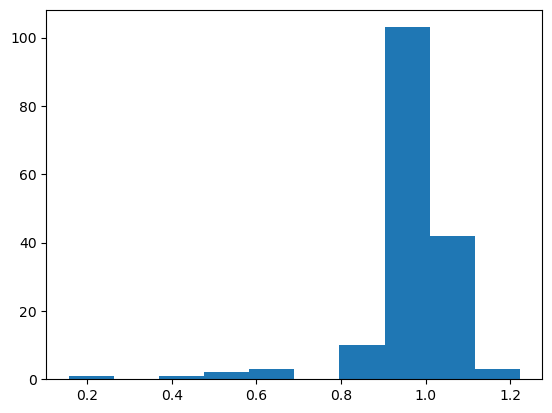

In [80]:

from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = df_entbact_train.columns
X_train = df_train.loc[:,covariates]
y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
model.fit(X_train, y_train) 
 
X_test = df_test.loc[:,covariates]
y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
from model_evaluation import evaluate_model
evaluate_model(model, X_train, X_test, y_train, y_test)

H_coeff = np.exp(model.coef_)
 
plt.hist(H_coeff)

 

In [83]:
#p = 10
#selection = abs(H_coeff-1) > p/100*np.std(H_coeff)
selection = abs(H_coeff-1) >0
print(np.mean(selection))
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = df_entbact_train.columns[selection]
X_train = df_train.loc[:,covariates]
y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
model.fit(X_train, y_train) 
 
X_test = df_test.loc[:,covariates]
y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
from model_evaluation import evaluate_model
evaluate_model(model, X_train, X_test, y_train, y_test)


1.0


,Harrell C,Concordance index IPCW,Integrated Brier Score,Hosmer-Lemeshow
train,0.681452,0.663428,0.017958,5.81e-04
test,0.466950,0.466118,0.020864,3.55e-03


In [85]:
taxa = ['Lactobacillaceae', 'Clostridiaceae', 'Collinsella', 'Blautia', 'Salmonella', 'Campylobacter', 'Shigella', 'Yersinia', 'Candida','Bacteroides', 'Proteobacteria'] #,'Faecalibacterium prausnitzii', 'Ruminococcus gnavus']
from sksurv.linear_model import CoxPHSurvivalAnalysis
model = CoxPHSurvivalAnalysis(alpha=0.1, ties='breslow', n_iter=100, tol=1e-09, verbose=0)
from model_evaluation import evaluate_model

taxa_to_keep = []
for t in taxa: 
    cols = [t in el for el in readcounts_df_train.columns]
    df_entbact_train = readcounts_df_train.loc[:, cols]
    df_entbact_test = readcounts_df_test.loc[:, cols]
    df_train = pheno_df_train.join(df_entbact_train)
    df_test  = pheno_df_test.join(df_entbact_test)
    
    covariates = df_entbact_train.columns
    X_train = df_train.loc[:,covariates]
    y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
    model.fit(X_train, y_train) 
    
    X_test = df_test.loc[:,covariates]
    y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
     
    H_coeff = np.exp(model.coef_)
    taxa_to_keep.append(covariates[np.abs(H_coeff-1)>0.1])
    

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  app.launch_new_instance()


ValueError: at least one array or dtype is required

In [89]:
taxa_to_keep = np.array(taxa_to_keep)
taxa_to_keep.shape

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(11,)

In [90]:
taxa_to_keep

array([Index(['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_animalis',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_brantae',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_capillatus',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_floricola',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_ghanensis',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_heilongjiangensis',
              'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus_nodensis',
              'k__Bacteria;p__Firmic

In [95]:
v = np.array([])
for el in taxa_to_keep:
    v = np.concatenate((v, np.array(el)))
 

In [99]:
np.save('taxa_to_keep.npy', taxa_to_keep)

# Train a gradient boosted tree using phenotype data + selected microbiome data

In [100]:
cols = [any(t in el for t in taxa_to_keep) for el in readcounts_df_train.columns]

df_entbact_train = readcounts_df_train.loc[:, cols]
df_entbact_test = readcounts_df_test.loc[:, cols]
df_train = pheno_df_train.join(df_entbact_train)
df_test  = pheno_df_test.join(df_entbact_test)

covariates = df_entbact_train.columns
X_train = df_train.loc[:,covariates]
y_train = df_train.loc[:,['Event', 'Event_time']].to_records(index=False)
model.fit(X_train, y_train) 

X_test = df_test.loc[:,covariates]
y_test =  df_test.loc[:,['Event', 'Event_time']].to_records(index=False)
     

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])


KeyboardInterrupt: 

In [ ]:
from pipeline import create_pipeline
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
model = create_pipeline(est_cph_tree)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)
